## OOI Lab Manual 2025: Lab 7 Water Masses: Activity 3 TS Diagrams

This notebook demonstrates how to access and process the dataset used in *Lab 7 Water Masses* in the 2025 edition of the *OOI Lab Manual*.

By Sage Lichtenwalner, Rutgers University

Revised: January 19, 2025

In [1]:
# Notebook Setup
from erddapy import ERDDAP
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

For this activity, we will create a TS Diagram with contour lines of density.

And then we will create an interactive version with data from June 2024 from the Surface Buoy CTD on the *Pioneer MAB Array Southern Surface Mooring* (ooi-cp11sosm-sbd11-06-metbka000).

In [2]:
# Setup a connection to the OOI ERDDAP server
server = "https://erddap.dataexplorer.oceanobservatories.org/erddap/"
e = ERDDAP(
    server=server,
    protocol="tabledap",
    response="csv",
)

In [3]:
url_ctd = e.get_download_url(
    dataset_id='ooi-cp11sosm-sbd11-06-metbka000',
    variables=['time', 'sea_surface_temperature', 'sea_surface_salinity'],
    constraints={"time>=": "2024-06-01", "time<=": "2024-07-01"}
)
df_ctd = pd.read_csv(url_ctd, index_col='time', parse_dates=True, skiprows=[1])

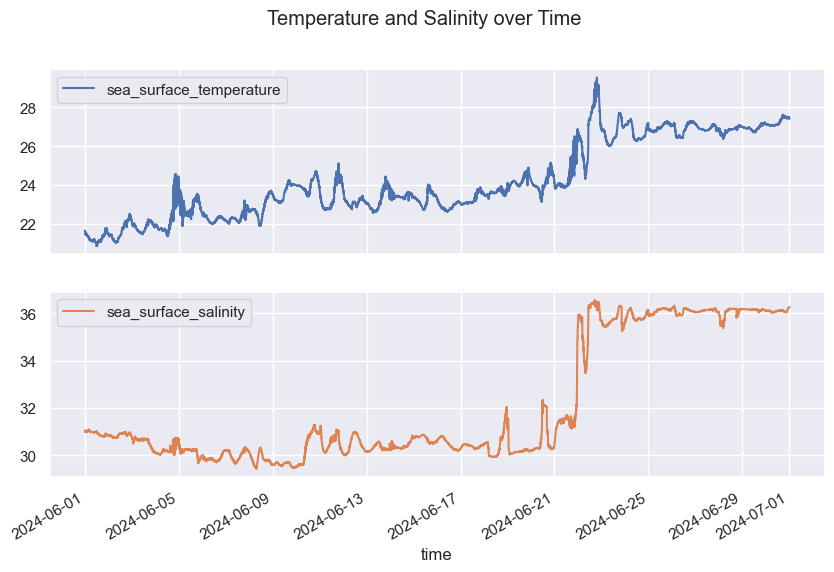

In [4]:
df_ctd[['sea_surface_temperature', 'sea_surface_salinity']].plot(subplots=True, figsize=(10, 6), title='Temperature and Salinity over Time')
plt.show()

<a list of 8 text.Text objects>

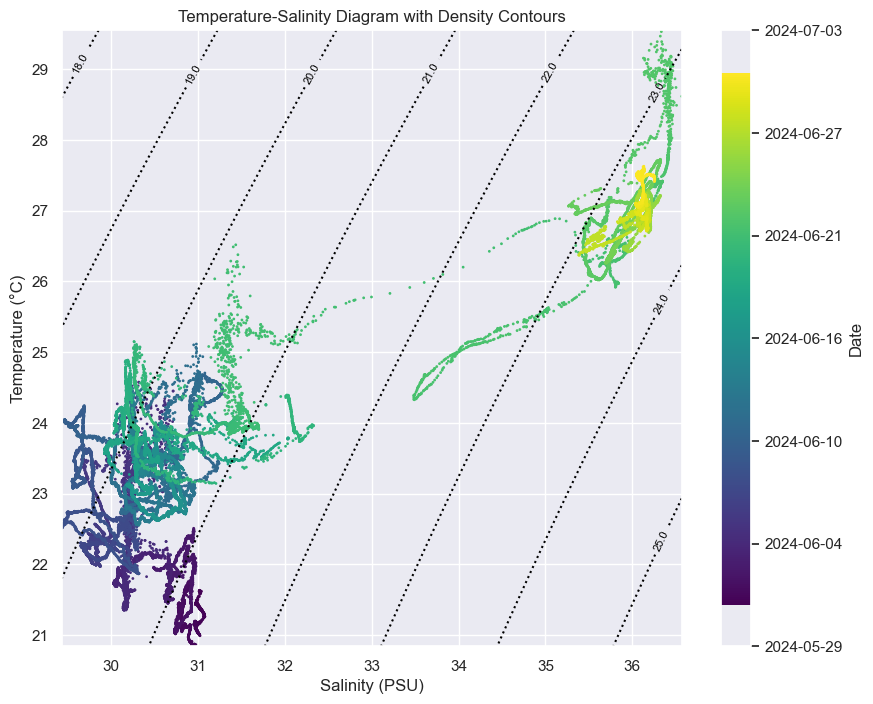

In [5]:
import matplotlib.dates as mdates
import gsw

# Calculate density
df_ctd['density'] = gsw.sigma0(df_ctd['sea_surface_salinity'], df_ctd['sea_surface_temperature'])

# Create TS diagram
plt.figure(figsize=(10, 8))
sc = plt.scatter(df_ctd['sea_surface_salinity'], df_ctd['sea_surface_temperature'], c=df_ctd.index, cmap='viridis', s=1)
cbar = plt.colorbar(sc, label='Date')
plt.xlabel('Salinity (PSU)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature-Salinity Diagram with Density Contours')

# Fix the colorbar ticks
import pandas as pd # We need pandas for this
ticks = cbar.get_ticks()
cbar.set_ticks(ticks)
cbar.set_ticklabels(pd.to_datetime(ticks).strftime(date_format='%Y-%m-%d'))
# cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%Y-%m-%d'));


# Add lines of constant density
S, T = np.meshgrid(
    np.linspace(df_ctd['sea_surface_salinity'].min(), df_ctd['sea_surface_salinity'].max(), 100),
    np.linspace(df_ctd['sea_surface_temperature'].min(), df_ctd['sea_surface_temperature'].max(), 100)
    )
density = gsw.sigma0(S, T)
contours = plt.contour(S, T, density, colors='black', linestyles='dotted')
plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')


## TS Diagram
Let's create a blank TS diagram

Text(0.5, 1.0, 'Temperature-Salinity Diagram')

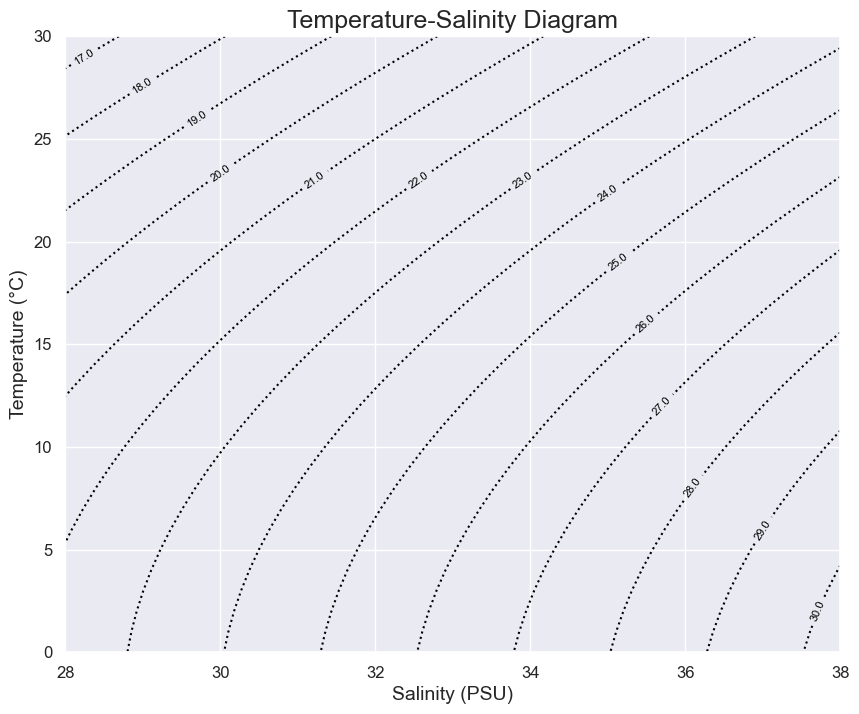

In [6]:
# Create TS diagram
plt.figure(figsize=(10, 8))

# Add lines of constant density
S, T = np.meshgrid(
    np.linspace(28, 38, 11),
    np.linspace(0, 30, 31)
)
density = gsw.sigma0(S, T)
contour_levels = np.arange(np.floor(density.min()), np.ceil(density.max()), 1)
contours = plt.contour(S, T, density, colors='black', linestyles='dotted', levels=contour_levels)
plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Salinity (PSU)', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.title('Temperature-Salinity Diagram', fontsize=18)

## Export Data

In [7]:
# Prepare data for JSON serialization
data = {
    'salinity': S[0].tolist(),
    'temperature': T[:, 0].tolist(),
    # 'density': density.flatten().tolist()
    'density': density.tolist()
}

# Save to JSON file
import json
with open('data/lab7_tsdiagram.json', 'w') as f:
    json.dump(data, f)

In [8]:
# Create hourly average and export the data
df_ctd_simple = df_ctd[['sea_surface_temperature', 'sea_surface_salinity']].copy()
print(df_ctd_simple.shape)

# Resample to hourly data
df_ctd_simple = df_ctd_simple.resample('1h').mean()
print(df_ctd_simple.shape)

# Create a 'week' column in df_ctd
df_ctd_simple['week'] = (df_ctd_simple.index - df_ctd_simple.index[0]).days // 7

# Simplify data columns
df_ctd_simple.index = df_ctd_simple.index.strftime('%Y-%m-%d %H:%M')
df_ctd_simple = df_ctd_simple.round(3)

# Export to CSV
df_ctd_simple.to_csv('data/lab7_ctd.csv')

data = {
    'date': df_ctd_simple.index.tolist(),
    'temperature': df_ctd_simple['sea_surface_temperature'].tolist(),
    'salinity': df_ctd_simple['sea_surface_salinity'].tolist(),
    'week': df_ctd_simple['week'].tolist()
}

# Save to JSON file
import json
with open('data/lab7_ctd.json', 'w') as f:
    json.dump(data, f)


(40034, 2)
(721, 2)


## Prototype Plotly Graphs

In [9]:
import plotly.graph_objects as go

# Create a new figure
fig = go.Figure()

# Add contour lines
fig.add_trace(go.Contour(
    x=S[0],
    y=T[:, 0],
    z=density,
    colorscale='Viridis',
    line=dict(smoothing=0.85),
    contours=dict(
        coloring='lines',
        showlabels=True,
        labelfont=dict(size=12, color='grey')
    ),
    showscale=False
))

# Create a 'week' column in df_ctd
df_ctd['week'] = (df_ctd.index - df_ctd.index[0]).days // 7

# Rename the weeks with the date range
week_labels = [f'June {i}-{i+6}' for i in range(1, 29, 7)]

# Add the CTD data for each week with new labels
for week, label in zip(df_ctd['week'].unique(), week_labels):
    week_data = df_ctd[df_ctd['week'] == week]
    fig.add_trace(go.Scatter(
        x=week_data['sea_surface_salinity'],
        y=week_data['sea_surface_temperature'],
        mode='markers',
        marker=dict(size=5),
        name=label
    ))

fig.update_layout(
    title='Temperature-Salinity Diagram',
    xaxis_title='Salinity (PSU)',
    yaxis_title='Temperature (°C)',
    xaxis=dict(tickfont=dict(size=12)),
    yaxis=dict(tickfont=dict(size=12)),
    width=800,
    height=600
)

# Export to HTML
fig.write_html("lab7_ts_diagram_contours.html")

# Show the plot
fig.show()
